# Libraries

In [34]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [55]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for index, filename in enumerate(files):

    if not index % 1000:
        print(index, " | ", end=" ")  # Counter
    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)  # Read file

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print(articles.size)

articles.sample(3)


0  |  1000  |  2000  |  3000  |  4000  |  5000  |  6000  |  7000  |  8000  |  9000  |  10000  |  11000  |  12000  |  13000  |  14000  |  15000  |  16000  |  17000  |  18000  |  19000  |  20000  |  21000  |  22000  |  23000  |  24000  |  25000  |  26000  |  108924


,year,title,url,subjects,orgs,people
16243,2012,Biomass plant plans face decision,http://www.bbc.co.uk/news/uk-wales-north-east-...,"[energy and power, electric light and power, l...","[Wrexham council, Rivers Trust, Kronospan Chir...",[]
2279,2016,Physical activity found to decrease risk of dy...,http://timesofindia.feedsportal.com/c/33039/f/...,"[research, medicine and health, diseases and c...","[Harvard University, Harvard Medical School]",[Marilyn Moy]
1854,2012,Will Algae Biofuels Hit the Highway?,http://www.forbes.com/sites/kensilverstein/201...,"[energy and power, air pollution, light, elect...",[Algae Biomass Association],"[Dan Simon, Nick Donowitz]"


In [57]:
articles.sample(3)

,year,title,url,subjects,orgs,people
9634,2020,AfDB nods power projects,http://www.daily-mail.co.zm/afdb-nods-power-pr...,"[energy and power, electric light and power, l...","[AfDB communications, African Development Bank...",[KALONDE NYATI]
12895,2020,Washington state lands commissioner Hilary Fra...,https://www.seattletimes.com/seattle-news/publ...,"[elections, politics and government, united st...","[Republican party, Public Disclosure Commission]","[Kuehl Pederson, Hilary Franz]"
12343,2018,Comment on Apple is rebuilding Maps from the g...,https://techcrunch.com/2018/06/29/apple-is-reb...,[computers and the internet],"[Google, Apple, Chevron, TomTom]","[Patrice Gautier, Apple SVP Eddy Cue]"


## Entities

In [93]:
entities = np.empty((0, 11), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "years",
        "urls",
        "titles",
        "cooccurrences",
        "slope",
        "color",
        'x',
        'y',
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
14,environment,subject,7515,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me...",None,None,None,None


# Analysis

## Filter

In [133]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
79,air pollution,subject,3313,"{2011: 72, 2012: 53, 2013: 157, 2014: 221, 201...",[http://www.miamiherald.com/2014/06/02/4153647...,[PSC member: new EPA plan will drive up power ...,"[energy and power, Clyde Holloway, electric li...",None,None,None,None


## Linear regression

In [102]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)

entities.sample(3)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
124,Associated Press,org,247,"{2011: 16, 2012: 15, 2013: 14, 2014: 31, 2015:...",[https://abcnews.go.com/Business/wireStory/hor...,[ Horsepower _ literally: Finnish horse show r...,"[energy and power, Helsinki International Hors...",1.872727,None,None,None
518,company reports,subject,236,"{2011: 3, 2012: 4, 2013: 8, 2014: 10, 2015: 11...",[https://www.prnewswire.com:443/news-releases/...,[Neptune Reports Fiscal 2020 Second Quarter Re...,"[corporations, Trudeau Corporation, Neptune Ve...",7.781818,None,None,None
391,mergers acquisitions and divestitures,subject,301,"{2011: 6, 2012: 2, 2013: 12, 2014: 18, 2015: 3...",[http://economictimes.indiatimes.com/industry/...,"[GIC plans to buy assets of Greenko for Rs 1,6...","[energy and power, light, electric light and p...",7.266667,None,None,None


## Colors

In [117]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = cmap(norm(row['slope']))

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
14,environment,subject,7515,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me...",159.557576,"(0.705673158, 0.01555616, 0.150232812, 1.0)",None,None


## Frequency

In [112]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Sunil Dahiya', 59078),
 ('Indian Institute of Tropical Meteorology', 27406),
 ('Greenpeace India', 24271),
 ('Ramachandra University', 50976),
 ('Aishwarya Sudhir', 1381)]

## UMAP

In [126]:
# reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=2, min_dist=.1, metric='cosine')
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

index_embedding = 0

for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(3)


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
902,waste materials and disposal,subject,299,"{2011: 7, 2012: 3, 2013: 10, 2014: 20, 2015: 2...",[http://www.straitstimes.com/asia/south-asia/n...,[New Delhi's poisonous air a perennial crisis ...,"[Vivek Shukla, air pollution, Naresh Yadav, Vi...",7.060606,"(0.705673158, 0.01555616, 0.150232812, 1.0)",-8.971924,3.345297
697,insects,subject,294,"{2011: 2, 2012: 4, 2013: 9, 2014: 5, 2015: 8, ...",[https://www.dailynews.com/2018/04/04/californ...,[California fights wildfires aggressively — bu...,"[Sierra Institute for Community, forests and f...",8.509091,"(0.705673158, 0.01555616, 0.150232812, 1.0)",6.433587,16.134199
517,corporations,subject,229,"{2011: 3, 2012: 4, 2013: 5, 2014: 11, 2015: 10...",[https://www.prnewswire.com:443/news-releases/...,[Neptune Reports Fiscal 2020 Second Quarter Re...,"[Trudeau Corporation, Neptune Ventures, José D...",7.739394,"(0.705673158, 0.01555616, 0.150232812, 1.0)",0.442555,-5.891131


## Clustering

In [130]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.5)
# clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters


clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values:
    values.remove(-1)

clusters = [
    [index for index, cluster in enumerate(clusters) if cluster == value]
    for value in values
]

len(clusters)


6

# Plotting

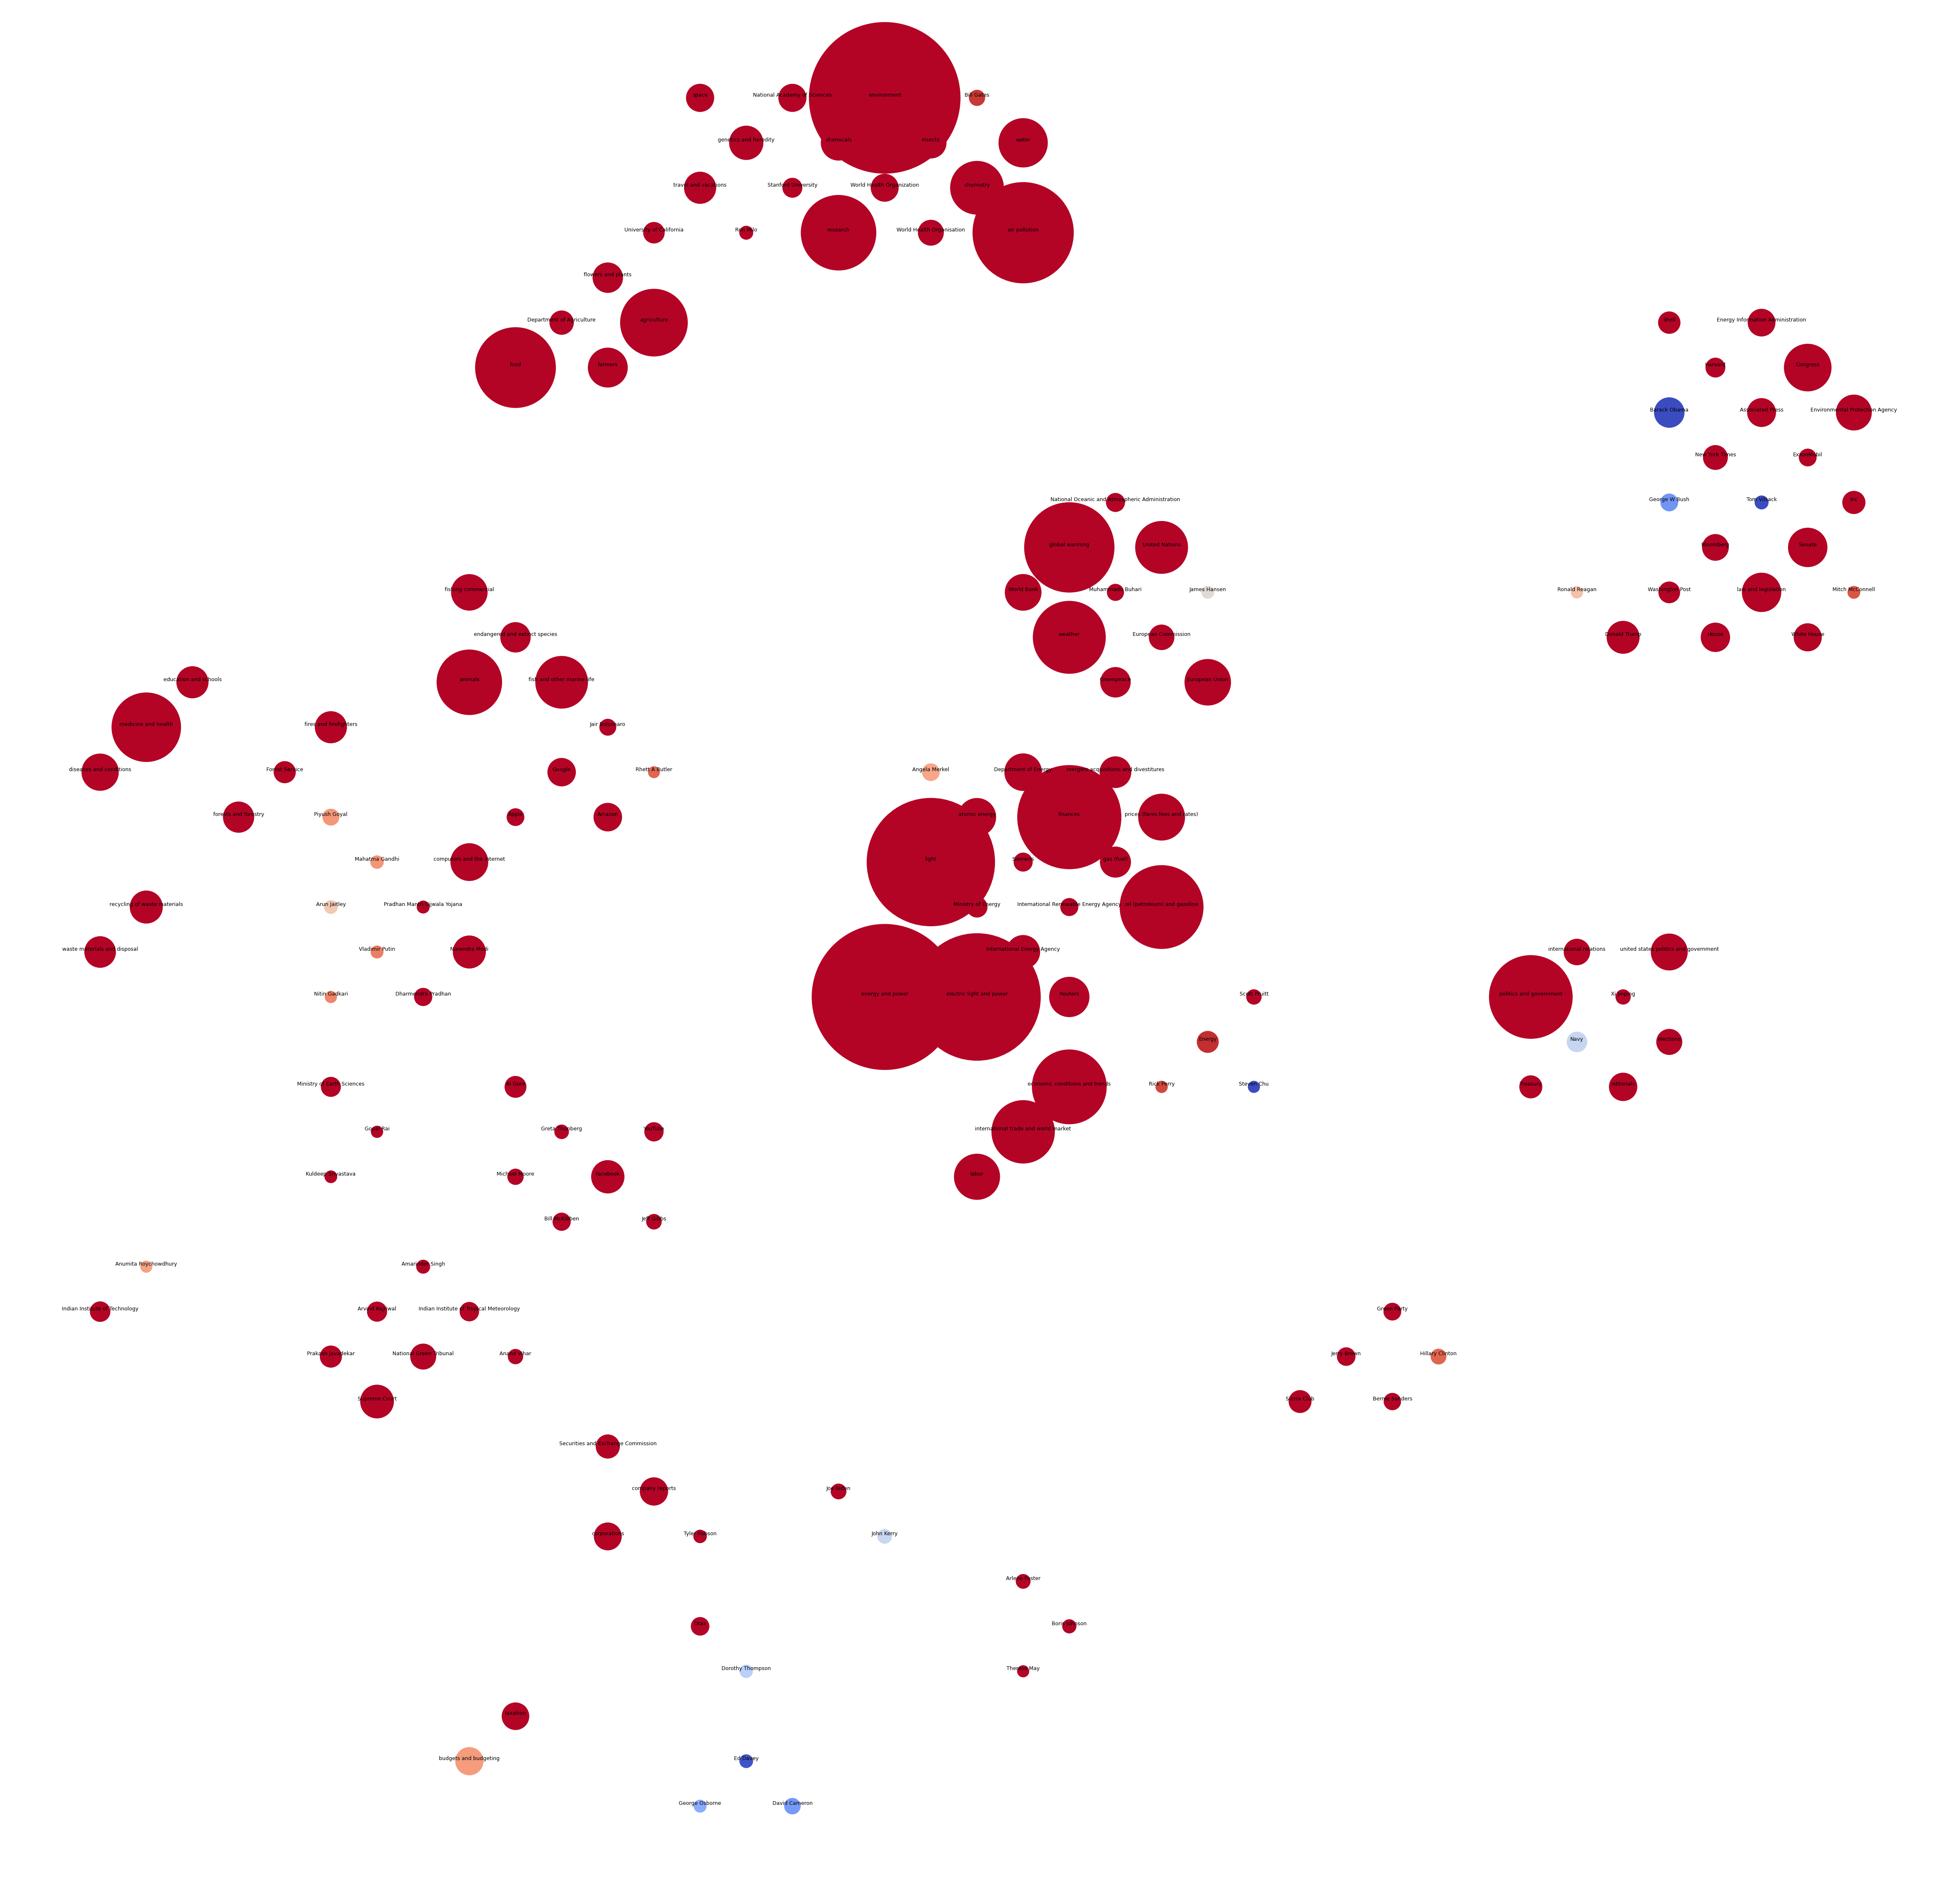

In [128]:
# Frame

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot



plt.scatter(entities['x'].to_list(), entities['y'].to_list(), s=entities['frequency'].to_list(), c=entities['color'].to_list())
# plt.scatter(x, y, s=40, c=colors)


# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row['name'], xy=(row['x'], row['y']), ha="center", va="bottom")
    text.set_fontsize(3)


# for i, txt in enumerate(orgs):
#     # text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(occurences[i]/math.pi)/40), ha='center', va='bottom')

plt.savefig("download.png")


# Save

In [134]:
entities.to_csv("src/data/entities.csv", index=False)

with open("src/data/clusters.csv", "w", encoding="UTF8") as file:
    file.write("cluster\n")
    for indexEmbedding, element in enumerate(embedding):
        value = None
        for indexCluster, cluster in enumerate(clusters):
            if indexEmbedding in cluster:
                value = indexCluster
        file.write(str(value) + "\n")